### Table of Contents

#### 1. Decision Tree Baseline Model

#### 2. Manually Fine-Tune 'max_depth' Hyperparameter

#### 3. Coarse GridSearchCV

#### 4. Finer GridSearchCV

#### 5. Feature Evaluation

#### 6. Conclusion

### Data Dictionary

The dataset is created by joining 5 tables and added dummy columns. For an overview of the data, please refer to the following data dictionary:

#### 1. sales columns

**store_nbr**: the store at which the products are sold.

**family**: the type of product sold.

**sales**: the total sales for a product family at a particular store on a given date. Fractional values are possible since products can be sold in

fractional units (e.g., 1.5 kg of cheese, as opposed to 1 bag of chips).

**onpromotion**: the total number of items in a product family that were being promoted at a store on a given date.

#### 2. stores columns

Store metadata, including **city, state, type, and cluster**.

cluster is a grouping of similar stores.

#### 3. oil column

**Daily oil price**. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

#### 4. holidays_events columns

Holidays and Events, with metadata

NOTE: Pay special attention to the **transferred** column. A holiday that is transferred officially falls on that calendar day, but was moved to

another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for 

the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which 

means it was celebrated on 2012-10-12. 

Days that are type **Bridge** are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made 

up by the type **Work Day** which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.

**Additional** holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (m aking Christmas Eve a holiday).

#### 5. Additional Notes on events

Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.

A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which 

greatly affected supermarket sales for several weeks after the earthquake

In [1]:
# import basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# read data
df=pd.read_csv("full_data_dropped_dummies.csv")
df.head()

,sales,onpromotion,store_trans,dcoilwtico_interpolated,store_nbr_1,store_nbr_10,store_nbr_17,store_nbr_18,store_nbr_2,store_nbr_3,...,description_eng_World Cup Brazil: Quarter Final,description_eng_World Cup Brazil: Semifinals,description_eng_World Cup Brazil: Third and fourth place,description_eng_World Football Inauguration Brazil,description_eng_foundation of Quito,year,month,day,weekday,weekend
0,1091.0,0,2111.0,93.14,1,0,0,0,0,0,...,0,0,0,0,0,2013,1,2,3,0
1,1060.0,0,2111.0,93.14,1,0,0,0,0,0,...,0,0,0,0,0,2013,1,2,3,0
2,579.0,0,2111.0,93.14,1,0,0,0,0,0,...,0,0,0,0,0,2013,1,2,3,0
3,2652.0,0,2111.0,93.14,1,0,0,0,0,0,...,0,0,0,0,0,2013,1,2,3,0
4,0.0,0,2111.0,93.14,1,0,0,0,0,0,...,0,0,0,0,0,2013,1,2,3,0


#### Split the dataset

In [3]:
# train_validation_test split
from sklearn.model_selection import train_test_split
X=df.drop("sales", axis=1)
y=df["sales"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=23)
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=23)

### 1. Decision Tree Baseline Model

In [4]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train2,y_train2)
print(f"baseline train r squared: {dt.score(X_train2,y_train2):.2f}")
print(f"baseline validation r squared: {dt.score(X_val,y_val):.2f}")

baseline train r squared: 1.00
baseline validation r squared: 0.92


#### Perfict fitting and over-fitting are seen in the training data. I will first try manually fine-tuning one hyperparameter to solve the problem.

### 2. Manually Fine-Tune 'max_depth' Hyperparameter

In [5]:
# check for train and val scores with different max_depths
depth = np.arange(1,118,10)
train_r2=[]
val_r2=[]
for d in depth:
    dt_m = DecisionTreeRegressor(max_depth=d, random_state=42)
    dt_m.fit(X_train2,y_train2)
    train_r2.append(dt_m.score(X_train2,y_train2))
    val_r2.append(dt_m.score(X_val,y_val))

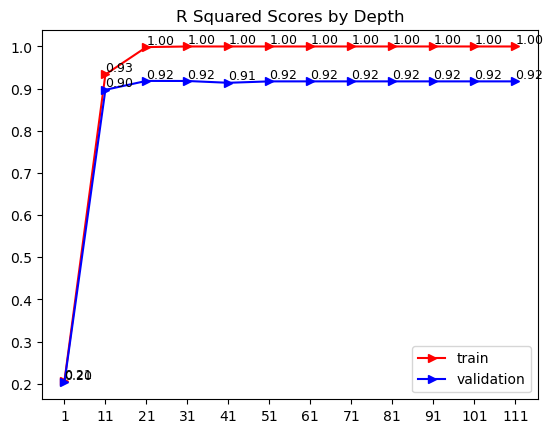

In [6]:
# plot the train & validation scores with different max_depths
plt.figure()
plt.plot(depth, train_r2, label='train', marker='>', c='r')
plt.plot(depth, val_r2, label='validation', marker='>', c='b')
plt.title('R Squared Scores by Depth')
plt.xticks(depth)
plt.legend()

for d, r2 in zip(depth,train_r2):
    plt.text(d, r2, f'{r2:.2f}', va="bottom", fontsize=9)
for d, r2 in zip(depth,val_r2):
    plt.text(d, r2, f'{r2:.2f}', va="bottom", fontsize=9)
plt.show()

#### After manually adjusting the max_depth parameter, the model shows the best result with max_depth set to 11. Beyond a max_depth of 21, the model demonstrates perfect fitting. To achieve a robust model and enhance the validation score, we will simultaneously adjust three hyperparameters.

#### To save the computation cost, we will use coarse GridSearchCV before moving on to finer GridSearch.

### 3. Coarse GridSearchCV

In [21]:
# import libraries
from sklearn.model_selection import GridSearchCV
# define the coarse parameter grid
coarse_grid_params = {
    'max_depth':[5,11,25,45],
    'min_samples_split':[2,5,20],
    'min_samples_leaf':[2,20,40]
}

In [22]:
# initialize the model
dt_crs = DecisionTreeRegressor(random_state=42)
# initialize GridSearchCV with coarse parameter grid
grid_search_crs = GridSearchCV(estimator=dt_crs, param_grid=coarse_grid_params, cv=5, n_jobs=-1)

In [23]:
# fit GridSearchCV
grid_search_crs.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 11, 25, 45],
                         'min_samples_leaf': [2, 20, 40],
                         'min_samples_split': [2, 5, 20]})

In [24]:
# check for the mean training score
mean_train_score = grid_search_crs.best_estimator_.score(X_train, y_train)
print(f"mean_best_train_score: {mean_train_score:.4f}")

mean_best_train_score: 0.9714


In [25]:
# get the best coarse params
best_params_crs = grid_search_crs.best_params_
# get the best validation score
best_val_score = grid_search_crs.best_score_
print(f"best_params_crs:{best_params_crs}")
print(f"mean_best_val_score:{best_val_score:.4f}")

best_params_crs:{'max_depth': 25, 'min_samples_leaf': 2, 'min_samples_split': 20}
mean_best_val_score:0.9327


#### After the coarse GridSearchCV, we can see that the model is slightly overfitting. To enhance the model further, I will use finer grains. 

### 4. Finer GridSearchCV

In [26]:
# define the finer parameter grid
fine_grid_params = {
    'max_depth':[40,45,55],
    'min_samples_split':[10,20,30],
    'min_samples_leaf':[2,4,6]
}

In [27]:
# initialize the model
dt_fine = DecisionTreeRegressor(random_state=42)
# initialize GridSearchCV with coarse parameter grid
grid_search_fine = GridSearchCV(estimator=dt_fine, param_grid=fine_grid_params, cv=5, n_jobs=-1)

In [28]:
# fit GridSearchCV
grid_search_fine.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [40, 45, 55],
                         'min_samples_leaf': [2, 4, 6],
                         'min_samples_split': [10, 20, 30]})

In [29]:
# check for the mean training score
mean_train_score = grid_search_fine.best_estimator_.score(X_train, y_train)
print(f"mean_best_train_score: {mean_train_score:.4f}")

mean_best_train_score: 0.9656


In [30]:
# get the best fine params
best_params_fine = grid_search_fine.best_params_
# get the best validation score
best_val_score = grid_search_fine.best_score_
print(f"best_params_fine:{best_params_fine}")
print(f"mean_best_val_score:{best_val_score:.4f}")

best_params_fine:{'max_depth': 40, 'min_samples_leaf': 6, 'min_samples_split': 20}
mean_best_val_score:0.9339


#### The difference between the training and validation scores is 0.026. Both scores are above 0.91, which indicates a robust model. Let's now check the test score and examine the decision tree split logic.

In [31]:
# check for the R2 test score
from sklearn.metrics import r2_score
y_pred = grid_search_fine.best_estimator_.predict(X_test)
test_r2 = r2_score(y_test,y_pred)
print(f"test_r2: {test_r2:.4f}")

test_r2: 0.9413


#### The test R squared score is 0.94. This shows that the model is robust. Let's check for Mean Absolute Error (MAE) and Mean Squared Error (MSE) to better understand model performance.

In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_test,y_pred)
print(f"test_mae: {mae:.4f}")
mse = mean_squared_error(y_test,y_pred)
print(f"test_mse: {mse:.4f}")

test_mae: 350.0527
test_mse: 543604.6969


### 5. Feature Evaluation: 

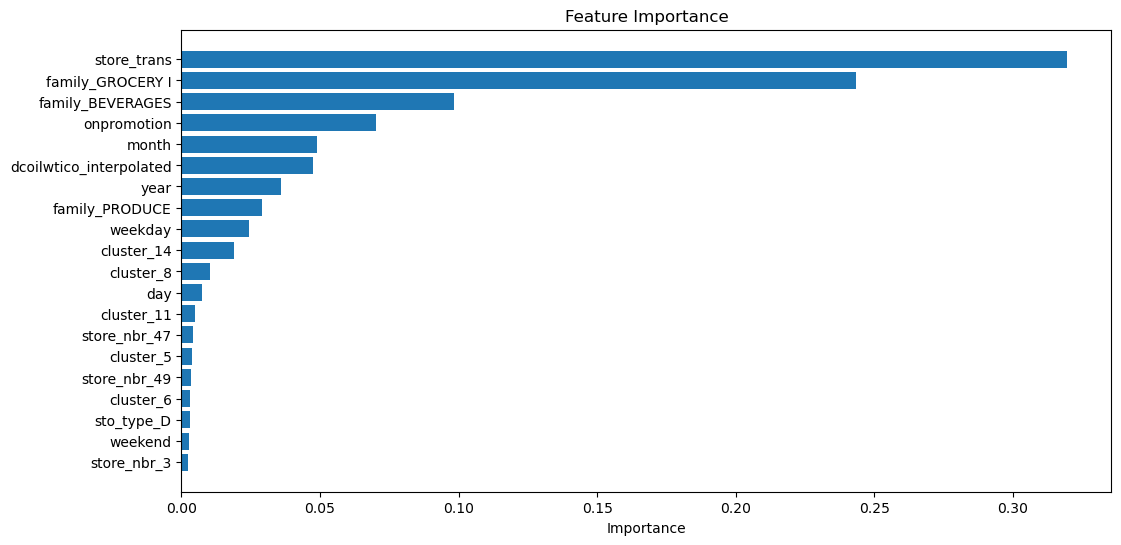

In [33]:
# get feature importance
# Check for important features of the best model
feature_importances = grid_search_fine.best_estimator_.feature_importances_
features = X_train2.columns

# Create a DataFrame for better visualization
feature_df = pd.DataFrame({'feature': features, 'importance': feature_importances})
feature_df = feature_df.sort_values(by='importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.barh(feature_df['feature'][:20], feature_df['importance'][:20])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

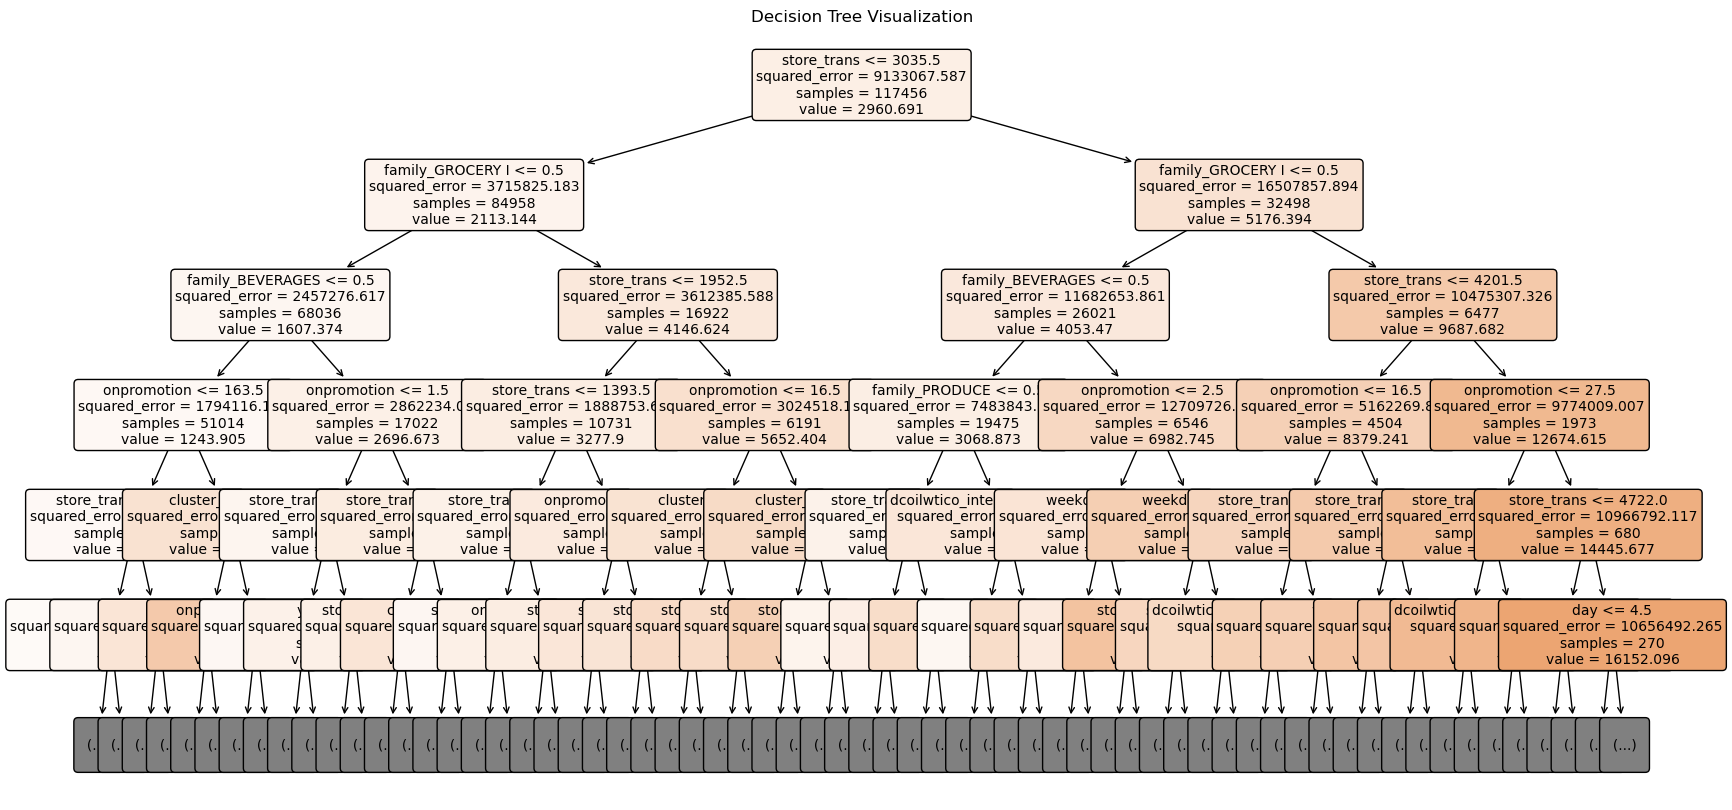

In [34]:
# visualize the tree
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(grid_search_fine.best_estimator_, filled=True, feature_names=X_train.columns, rounded=True, fontsize=10, max_depth=5)
plt.title("Decision Tree Visualization")
plt.savefig('decision_tree.png', dpi=300)

### 6. Conclusion: 
#### Compared to the Linear Regression, the R² score increased from 0.68 to 0.94, indicating a significant improvement in the model's explanatory power. The Mean Absolute Error (MAE) dropped from 1210 to 350, and the Mean Squared Error (MSE) decreased from 2,968,663 to 543,604. 

#### "store_trans", "family_GROCERY I", "family_BEVERAGES", "onpromotion" are most important features.